# Cloud DataLoaders with Deeplake

In [7]:
import deeplake
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

### log in to deeplake


In [ ]:
!activeloop login -u username -p password

## Load dataset

In [3]:
dataset = deeplake.load('hub://sinzlab/hello_world')

hub://sinzlab/hello_world loaded successfully.
This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/sinzlab/hello_world


#### Visualizing the dataset in the cloud

The dataset can be visualized at https://app.activeloop.ai/sinzlab/home
- ask Konsti for an invitation to the sinzlab organization on activeloop

#### Dataset summary

In [4]:
dataset.summary()

Dataset(path='hub://sinzlab/hello_world', tensors=['images', 'responses'])

  tensor     htype        shape         dtype  compression
  -------   -------      -------       -------  ------- 
  images     image   (2304, 100, 100)   uint8    jpeg   
 responses  generic    (2304, 1244)    float32   None   


This is a demo dataset, with ~2000 images from imagenet, and the corresponding neuronal responses of the state-of-the-art monkey v4 model with 1244 neurons

## Accessing data

In [5]:
dataset.images[0]

Tensor(key='images', index=Index([0]))

In [6]:
img = dataset.images[0].numpy()

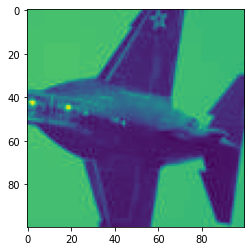

In [8]:
plt.imshow(img)

In [9]:
responses  = dataset.responses[0].numpy()

In [10]:
responses

array([0.6244133 , 0.3053959 , 0.8858251 , ..., 0.3579052 , 0.12414705,
       0.40183482], dtype=float32)

In [11]:
responses.shape

(1244,)

In [12]:
all_responses = dataset.responses.numpy()

In [13]:
all_responses.shape

(2304, 1244)

## Build PyTorch DataLoaders from the cloud

In [14]:
tform = transforms.Compose([
    transforms.ToPILImage(), # Must convert to PIL image for subsequent operations to run
    transforms.ToTensor(), # Must convert to pytorch tensor for subsequent operations to run
    transforms.Normalize([0.4876], [0.2756,]), # images are grayscale, mean and std are taken from our actual monkey data
])


dataloader = dataset.pytorch(tensors=("responses","images"), 
                        num_workers=0, 
                        batch_size=64, 
                        transform={'images': tform,  'responses': None}, 
                        shuffle=False)

/usr/local/lib/python3.8/dist-packages/deeplake/integrations/pytorch/common.py:91: UserWarning: Decode method for tensors ['images'] is defaulting to numpy. Please consider specifying a decode_method in .pytorch() that maximizes the data preprocessing speed based on your transformation.
  warnings.warn(


In [15]:
batch = next(iter(dataloader))

In [16]:
batch.keys()

odict_keys(['images', 'responses'])

In [17]:
batch["responses"]

tensor([[0.6244, 0.3054, 0.8858,  ..., 0.3579, 0.1241, 0.4018],
        [0.5083, 0.1695, 0.2338,  ..., 0.3333, 0.1076, 0.6338],
        [0.5102, 0.2323, 0.2487,  ..., 0.3413, 0.0910, 0.4078],
        ...,
        [0.5892, 0.2074, 0.6842,  ..., 0.4278, 0.1130, 0.3655],
        [1.2228, 1.0822, 1.0238,  ..., 0.2818, 0.0919, 0.4622],
        [0.5187, 0.1468, 0.2900,  ..., 0.4276, 0.1125, 0.4158]])

In [18]:
batch["responses"].shape

torch.Size([64, 1244])

In [19]:
batch["images"].shape

torch.Size([64, 1, 100, 100])

---

# Advances operations

### Copy the dataset to a local disk

In [21]:
deeplake.copy(src='hub://sinzlab/hello_world', 
              dest="/data/deep_lake/copy_example/",
              overwrite=True) 

hub://sinzlab/hello_world loaded successfully.
This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/sinzlab/hello_world


Evaluating copy transform: 85%|████████▍ | 1956/2304 [00:12<00:02

Dataset(path='/data/deep_lake/copy_example/', tensors=['images', 'responses'])

Evaluating copy transform: 100%|██████████| 2304/2304 [00:29<00:00

### Create Dataloader from local files

In [22]:
dataset_local = deeplake.load('/data/deep_lake/copy_example/')

/data/deep_lake/copy_example/ loaded successfully.


In [23]:
tform = transforms.Compose([
    transforms.ToPILImage(), # Must convert to PIL image for subsequent operations to run
    transforms.ToTensor(), # Must convert to pytorch tensor for subsequent operations to run
    transforms.Normalize([0.4876], [0.2756,]),
])


dataloader_local = dataset_local.pytorch(tensors=("responses","images"), 
                        num_workers=0, 
                        batch_size=64, 
                        transform={'images': tform,  'responses': None}, 
                        shuffle=False)

/usr/local/lib/python3.8/dist-packages/deeplake/integrations/pytorch/common.py:91: UserWarning: Decode method for tensors ['images'] is defaulting to numpy. Please consider specifying a decode_method in .pytorch() that maximizes the data preprocessing speed based on your transformation.
  warnings.warn(


In [25]:
from tqdm import tqdm

In [26]:
for b in tqdm(dataloader_local):
    pass


100%|██████████| 36/36 [00:01<00:00, 26.19it/s]


### compare with cloud loading

In [27]:
for b in tqdm(dataloader):
    pass


Evaluating copy transform: 100%|██████████| 2304/2304 [01:34<00:00

100%|██████████| 36/36 [00:16<00:00,  2.19it/s]


cloud loading takes 10 seconds to buffer, but will then be quite fast